# Recovery of gold from ore

I have to prepare a prototype machine learning model for "Digits". The company develops solutions for the efficient operation of industrial enterprises.

The model should predict the recovery rate of gold from gold ore. Use data with mining and cleaning parameters.

The model will help optimize production so as not to launch an enterprise with unprofitable characteristics.

I need:

1. Prepare data;
2. Conduct exploratory data analysis;
3. Build and train the model.

## Data processing

I load the libraries necessary for research.

In [186]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
colormap = plt.cm.GnBu_r
from sklearn.metrics import mean_absolute_error, accuracy_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor 

!pip3 install catboost


Defaulting to user installation because normal site-packages is not writeable


I import the studied datasets. They are pre-divided into training and test sets. Plus there is a dataset with the original data.

In [187]:
train = pd.read_csv('/datasets/gold_recovery_train.csv') #train sample
test = pd.read_csv('/datasets/gold_recovery_test.csv') #test sample
full_data = pd.read_csv('/datasets/gold_recovery_full.csv') #initial data

I create a function for the initial evaluation of data - the size of datasets, the researching of datasets "at a glance", a heat map.

In [188]:
def take_a_look(df):
    print(df.shape)
    print()
    print(df.head())
    print()
    plt.figure(figsize=(50, 50))
    sns.heatmap(df.corr(), annot=True, square=True, center=0, fmt='.1g', cmap=colormap, xticklabels=True, yticklabels=True)

I am researching the provided datasets.

(22716, 87)

                  date  final.output.concentrate_ag  \
0  2016-01-15 00:00:00                     6.055403   
1  2016-01-15 01:00:00                     6.029369   
2  2016-01-15 02:00:00                     6.055926   
3  2016-01-15 03:00:00                     6.047977   
4  2016-01-15 04:00:00                     6.148599   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                     9.889648                      5.507324   
1                     9.968944                      5.257781   
2                    10.213995                      5.383759   
3                     9.977019                      4.858634   
4                    10.142511                      4.939416   

   final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
0                    42.192020              70.541216             10.411962   
1                    42.701629              69.266198             10.462676   
2                    42.657501    

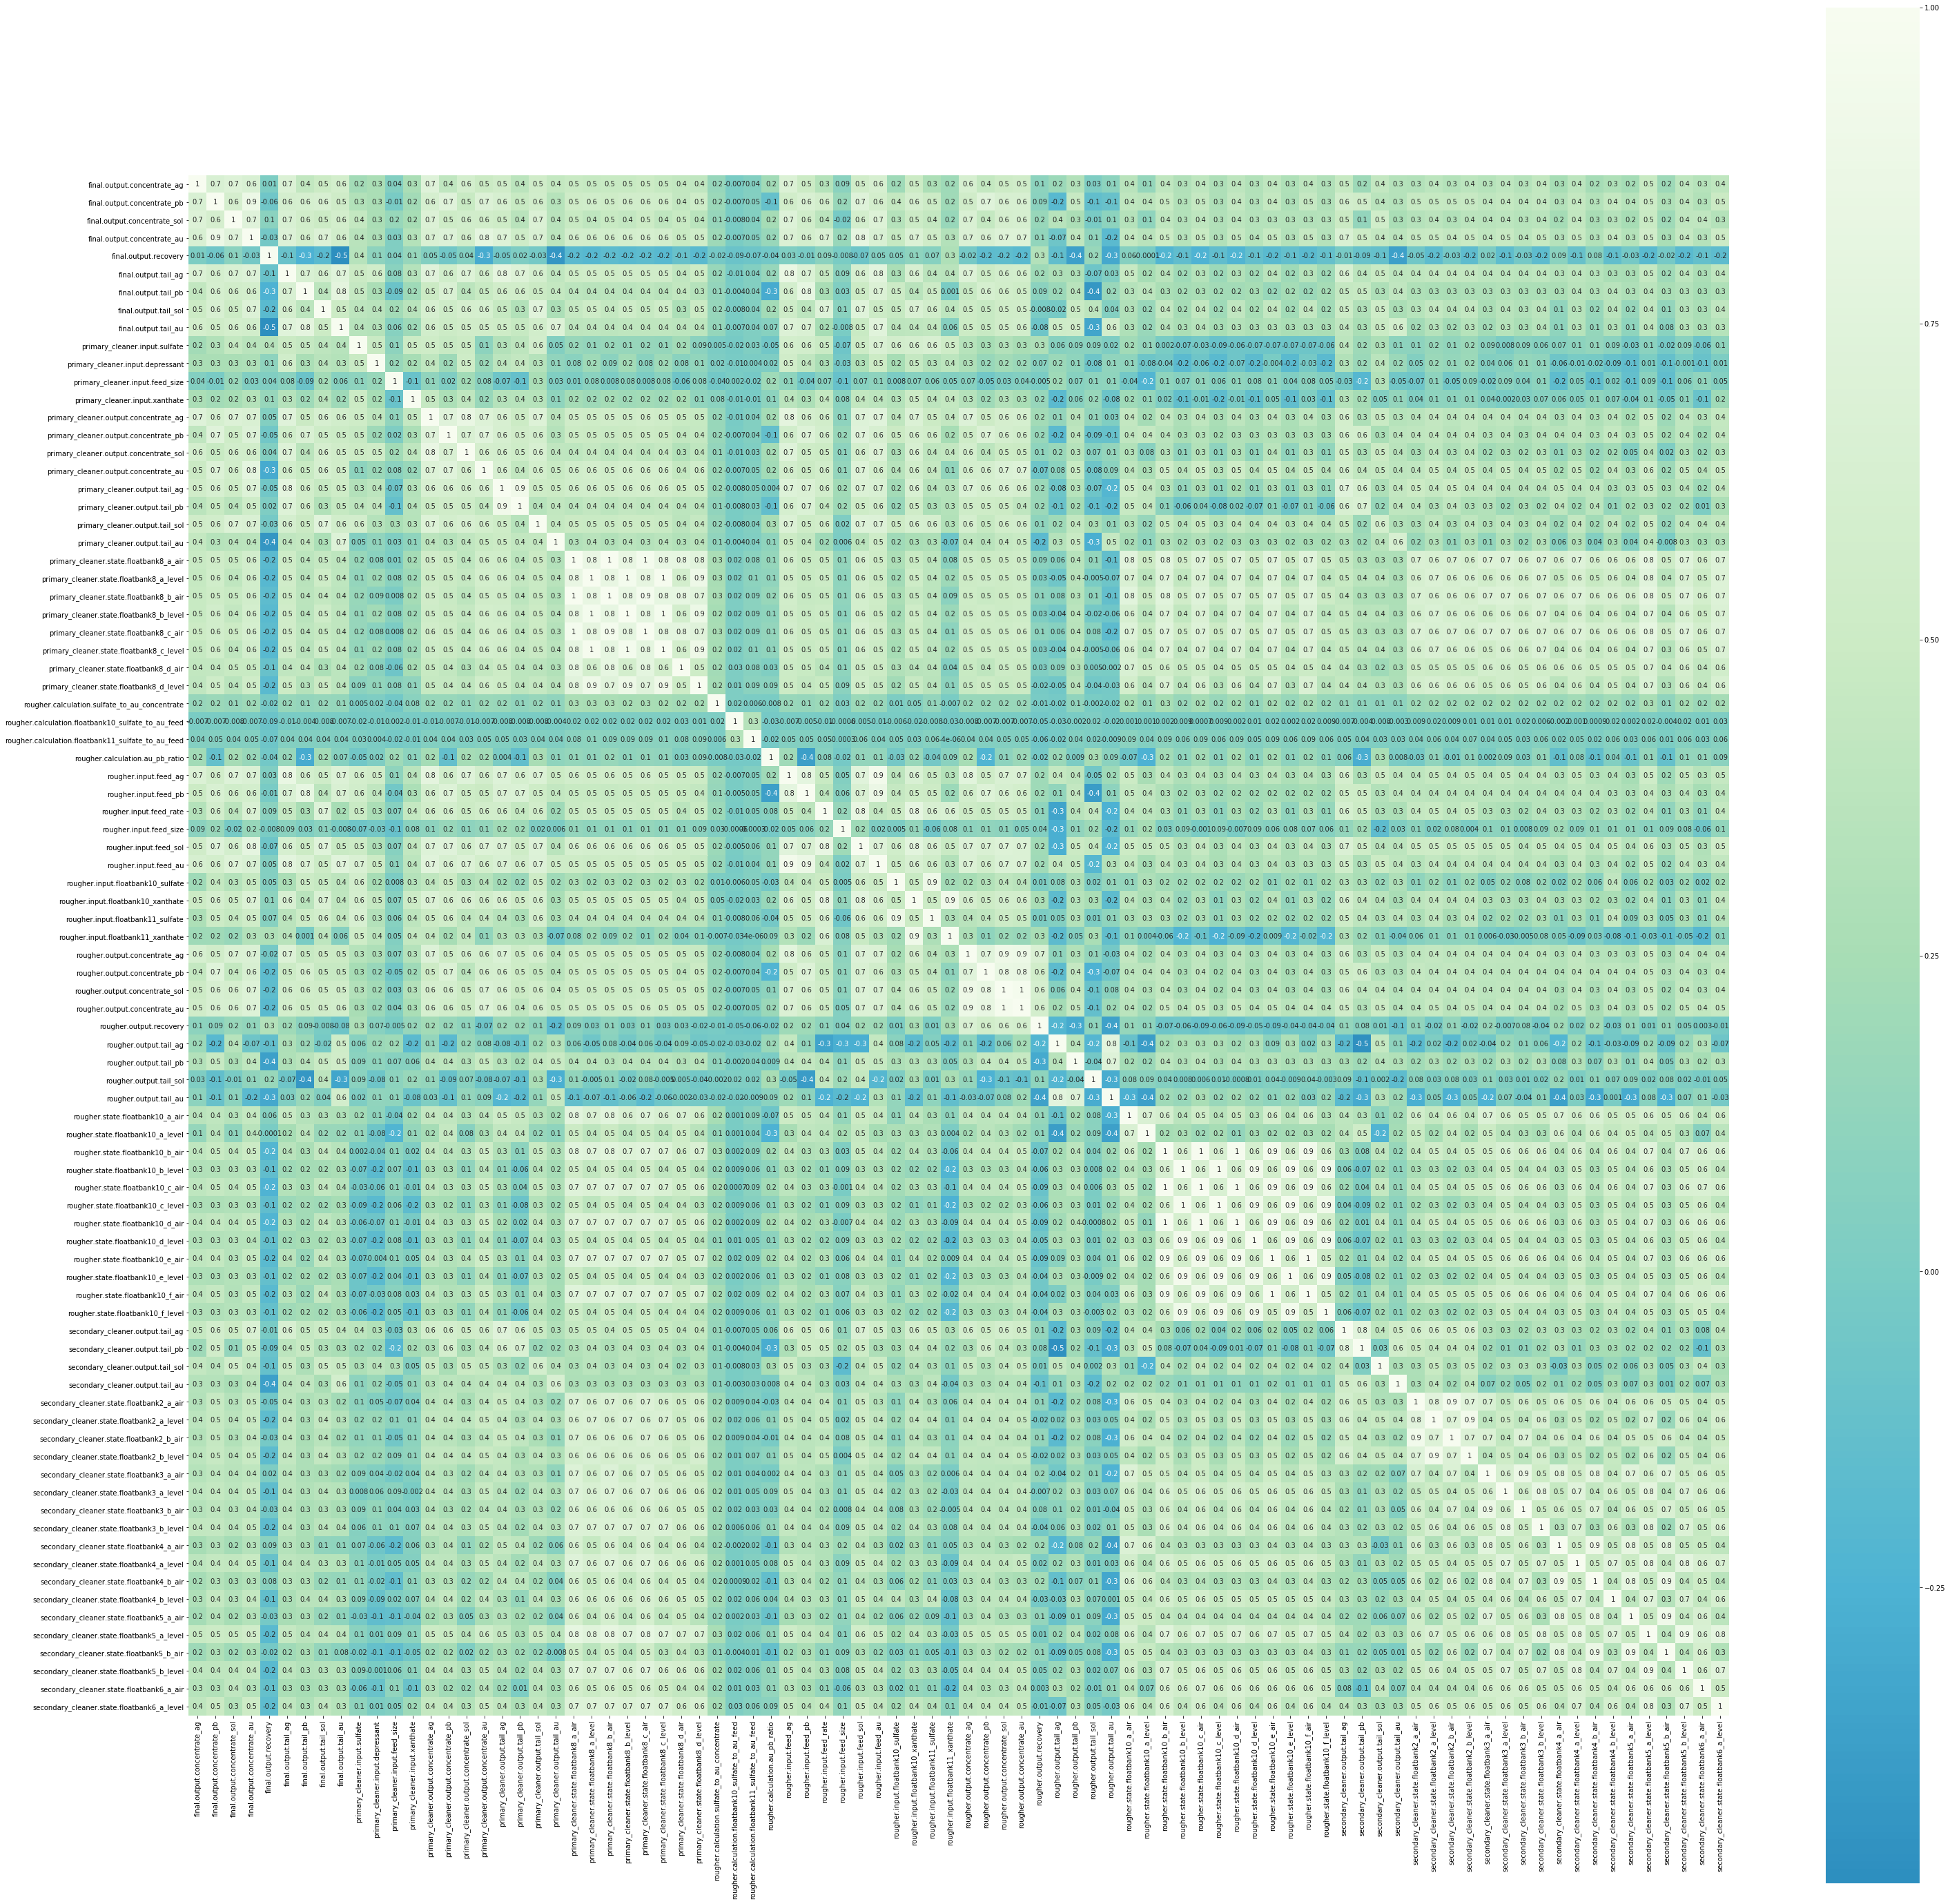

In [189]:
take_a_look(full_data)

In [190]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

It turned out that there are missing values, and more or less serious correlations in the total amount of data do not look threatening for future calculations. Let's check for duplicates.

In [191]:
print ('Дубликаты')
print()
print('Обучающая выборка: ',train.duplicated().sum())
print('Тестовая выборка: ',test.duplicated().sum())
print('Исходные данные: ',full_data.duplicated().sum())

Дубликаты

Обучающая выборка:  0
Тестовая выборка:  0
Исходные данные:  0


Great, no duplicates found, let's check the correctness of the calculation of the enrichment efficiency.

In [192]:
def recov(c,f,t):

    recovery = (c*(f-t)) / (f*(c-t)) * 100
    #fill in values that are too big and too small with gaps
    recovery[recovery<0] = np.nan
    recovery[recovery>100] = np.nan
    
    return recovery

Removing gaps in the rougher.output.recovery column

In [193]:
train.dropna(subset = ['rougher.output.recovery'], inplace = True)

In [194]:
#создаем переменные, указанные в формуле
c = train['rougher.output.concentrate_au']
f = train['rougher.input.feed_au']
t = train['rougher.output.tail_au']

recovery_list = recov(c,f,t)

In [195]:
old_recovery = train['rougher.output.recovery']

I build histograms for two sets of recovery indicator values

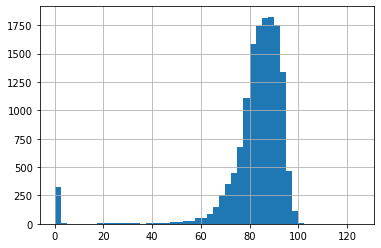

In [196]:
train['rougher.output.recovery'].hist(bins=50, range=(0, 125))

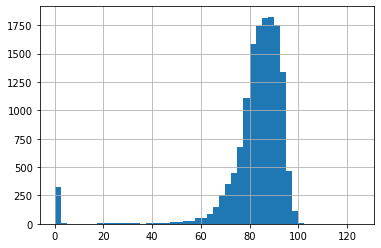

In [197]:
recov(c,f,t).hist(bins=50, range=(0, 125))

The graphs are distributed evenly, they are identical.

In [198]:
#подсчет MAE и заполнение nan значений на нулевые
mae = mean_absolute_error(train['rougher.output.recovery'].fillna(0),recovery_list.fillna(0))
print('Mean Absolute Error:', mae)

Mean Absolute Error: 9.444891926100695e-15


The mean absolute deviation is very small, there are no differences between the data.

In [199]:
print(train.shape)
print(test.shape)

(14287, 87)
(5856, 53)


After assessing the scale of the test and training samples, it can be seen that almost half of the columns are missing from the test sample. Let's search the missing features.

In [200]:
lost_columns = train.columns.drop(test.columns)
train[lost_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14287 entries, 0 to 16859
Data columns (total 34 columns):
final.output.concentrate_ag                           14282 non-null float64
final.output.concentrate_pb                           14282 non-null float64
final.output.concentrate_sol                          14055 non-null float64
final.output.concentrate_au                           14283 non-null float64
final.output.recovery                                 14149 non-null float64
final.output.tail_ag                                  14287 non-null float64
final.output.tail_pb                                  14173 non-null float64
final.output.tail_sol                                 14279 non-null float64
final.output.tail_au                                  14287 non-null float64
primary_cleaner.output.concentrate_ag                 14287 non-null float64
primary_cleaner.output.concentrate_pb                 14164 non-null float64
primary_cleaner.output.concentrate_sol      

The listed columns are the concentration and amount of tailings of various substances, as well as the calculated characteristics.
Thus, we have 53 features (those in the test sample) with 2 target features (rougher.output.recovery and final.output.recovery). Remove the missing features from the training set and add the target features to the test set.

In [201]:
columns_to_drop = lost_columns.drop(['final.output.recovery', 'rougher.output.recovery'])
right_columns = train.columns.drop(columns_to_drop)
train = train[right_columns]

The unique values from the date column will be used as indexes when concatenating.

In [202]:
target_features_to_join = full_data[['date', 'final.output.recovery', 'rougher.output.recovery']].copy()

In [203]:
test = test.join(target_features_to_join.set_index('date'), on='date')

It is also necessary to get rid of the nan values in the target features of both samples.

In [204]:
train.dropna(subset = ['final.output.recovery', 'rougher.output.recovery'], inplace = True)
test.dropna(subset = ['final.output.recovery', 'rougher.output.recovery'], inplace = True)

In [205]:
test.reset_index(drop=True, inplace=True)
train.reset_index(drop=True, inplace=True)

In [206]:
print(train.shape)
print(test.shape)

(14149, 55)
(5290, 55)


###### Conclusion:

The training and test samples, separated by about 25% and 75%, are cleared of duplicates and gaps in the target features. Data prepared for analysis.

## Data analysis

To begin with, it is necessary to evaluate how the concentration of various substances changes at various stages of production. Let's divide the data by the names of substances and draw diagrams for each sample.

In [207]:
au_data = (full_data[[
    'rougher.input.feed_au', 
    'rougher.output.concentrate_au', 
    'primary_cleaner.output.concentrate_au', 
    'final.output.concentrate_au']].copy())

ag_data = (full_data[[
    'rougher.input.feed_ag', 
    'rougher.output.concentrate_ag', 
    'primary_cleaner.output.concentrate_ag', 
    'final.output.concentrate_ag']].copy())

pb_data = (full_data[[
    'rougher.input.feed_pb', 
    'rougher.output.concentrate_pb', 
    'primary_cleaner.output.concentrate_pb', 
    'final.output.concentrate_pb']].copy())

To create graphs, I will prepare a function.

In [208]:
def draw_hist (data, title):
    fig, ax = plt.subplots()
    ax.set_ylabel('Кол-во наблюдений')
    ax.set_xlabel('Концентрация металла')
    ax.set_title(title)
    for col in data:
        data[col].hist(alpha=.3) 
        ax.legend(['Исходное сырье','Флотация','Первичная очистка', 'Вторичная очистка'])

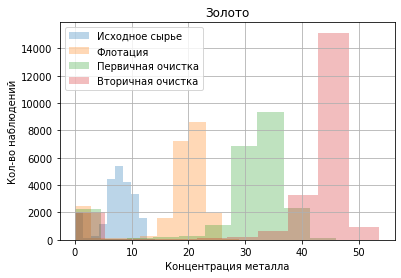

In [209]:
draw_hist(au_data, 'Золото')

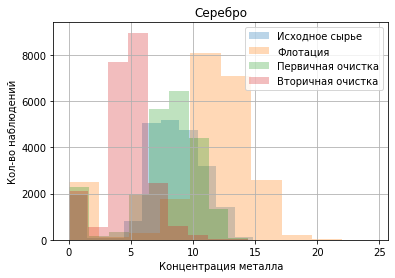

In [210]:
draw_hist(ag_data, 'Серебро')

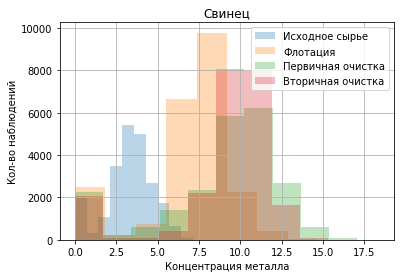

In [211]:
draw_hist(pb_data, 'Свинец')

It can be seen that the concentration of gold increases with each stage of purification - you can see how the production is doing its job. The silver content is significantly reduced during the primary and secondary purification process. The lead concentration increases during the flotation and primary purification process. There are many nulls in the data - probably not measured for these values.

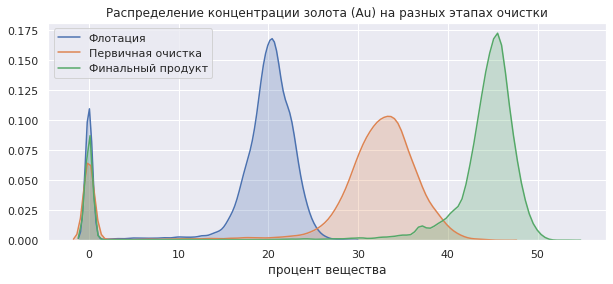

It is necessary to compare the sizes of raw material granules on the training and test samples - if their distributions are different, the model will be evaluated incorrectly.

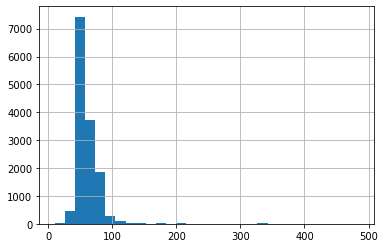

In [212]:
train['rougher.input.feed_size'].hist(bins=30)

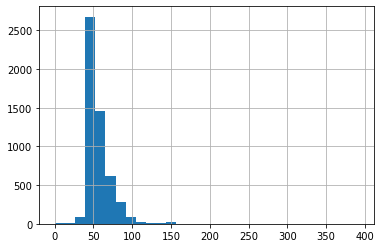

In [213]:
test['rougher.input.feed_size'].hist(bins=30)

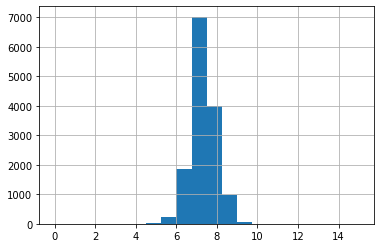

In [214]:
train['primary_cleaner.input.feed_size'].hist(bins=20, range=(0, 15))

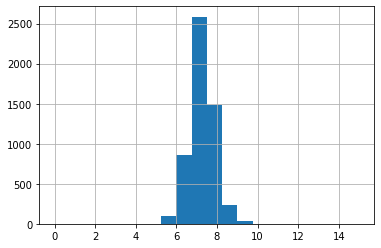

In [215]:
test['primary_cleaner.input.feed_size'].hist(bins=20, range=(0, 15))

The distributions of both samples are close to normal and are almost identical. This data will not interfere with the calculations.

I research the total concentration of all substances at different stages: in raw materials, in rough and final concentrates. To do this, I create a new dataset with the necessary columns.

In [216]:
concentrate_data = full_data[['date','rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol', 'rougher.input.feed_au', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au']].copy()
concentrate_data['conc_sum_rougher'] = concentrate_data['rougher.input.feed_ag'] + concentrate_data['rougher.input.feed_pb'] + concentrate_data['rougher.input.feed_sol'] + concentrate_data['rougher.input.feed_au']
concentrate_data['conc_sum_primary'] = concentrate_data['primary_cleaner.output.concentrate_ag'] + concentrate_data['primary_cleaner.output.concentrate_pb'] + concentrate_data['primary_cleaner.output.concentrate_sol'] + concentrate_data['primary_cleaner.output.concentrate_au']
concentrate_data['conc_sum_final'] = concentrate_data['final.output.concentrate_ag'] + concentrate_data['final.output.concentrate_pb'] + concentrate_data['final.output.concentrate_sol'] + concentrate_data['final.output.concentrate_au']

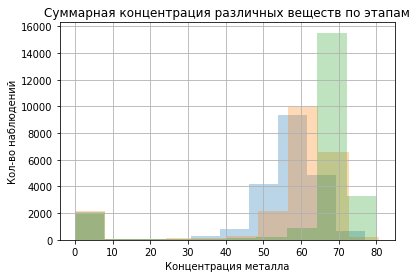

In [217]:
fig, ax = plt.subplots()
ax.set_ylabel('Кол-во наблюдений')
ax.set_xlabel('Концентрация металла')
ax.set_title('Суммарная концентрация различных веществ по этапам')
concentrate_data['conc_sum_rougher'].hist(alpha=.3)
concentrate_data['conc_sum_primary'].hist(alpha=.3)
concentrate_data['conc_sum_final'].hist(alpha=.3)

Let's get rid of zero values due to their anomaly.

In [218]:
zeros = (concentrate_data[['date', 'conc_sum_rougher', 'conc_sum_primary', 'conc_sum_final']]
           .copy()
           .query('conc_sum_rougher == 0 or conc_sum_primary == 0 or conc_sum_final == 0')
           .fillna(0))

In [219]:
test = test.join(zeros.set_index('date'), on='date')
test[['conc_sum_rougher', 'conc_sum_primary', 'conc_sum_final']] = (test[['conc_sum_rougher', 'conc_sum_primary', 'conc_sum_final']]
                                                                    .fillna(-1))
test = test.query('conc_sum_rougher == -1 and conc_sum_primary == -1 and conc_sum_final == -1')


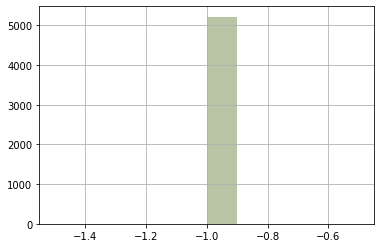

In [220]:
test['conc_sum_rougher'].hist(alpha=.2)
test['conc_sum_primary'].hist(alpha=.2)
test['conc_sum_final'].hist(alpha=.2)

In [221]:
test.drop(['conc_sum_rougher', 'conc_sum_primary', 'conc_sum_final'], axis='columns', inplace=True)

In [222]:
train = train.join(zeros.set_index('date'), on='date')
train[['conc_sum_rougher', 'conc_sum_primary', 'conc_sum_final']] = (train[['conc_sum_rougher', 'conc_sum_primary', 'conc_sum_final']]
                                                                    .fillna(-1))
train = train.query('conc_sum_rougher == -1 and conc_sum_primary == -1 and conc_sum_final == -1')
train.drop(['conc_sum_rougher', 'conc_sum_primary', 'conc_sum_final'], axis='columns', inplace=True)

In [223]:
test.dropna(inplace=True)
train.dropna(inplace=True)

In [224]:
print(train.shape)
print(test.shape)

(12593, 55)
(5169, 55)


###### Conclusion:

The data is cleared of anomalies and prepared for training and testing the model.

## Model

First, I create a function for calculating sMAPE (Symmetric Mean Absolute Percentage Error).

In [225]:
def smape (target, predictions):
    return 100/len(target) * np.sum(2 * np.abs(predictions - target) / (np.abs(target) + np.abs(predictions)))

And a function for calculating the final sMAPE.

In [226]:
def final_smape (rougher, final):
    return 0.25 * rougher + 0.75 * final

In [227]:
my_scorer = make_scorer(smape, greater_is_better=False)

I create separate features and target dataframes for the training sample.

In [228]:
target_rougher = train['rougher.output.recovery']
target_final = train['final.output.recovery']
features_train = train.drop(['date', 'final.output.recovery', 'rougher.output.recovery'], axis='columns')

Features scaling.

In [229]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)

I conduct cross-validation on different models to choose the best result.

In [230]:
model_dtr = DecisionTreeRegressor(random_state=12345)

print('DecisionTreeRegressor')
print ('Значение встроенной метрики:', cross_val_score(model_dtr, features_train, target_rougher, cv=3).mean())
print ('Значение sMAPE:', cross_val_score(model_dtr, features_train, target_rougher, cv=3, scoring=my_scorer).mean())


DecisionTreeRegressor
Значение встроенной метрики: -2.5703382249342814
Значение sMAPE: -19.416394200042486


In [231]:
model_lr = LinearRegression()

print('LinearRegression')
print ('Значение встроенной метрики:', cross_val_score(model_lr, features_train, target_rougher, cv=3).mean())
print ('Значение sMAPE:', cross_val_score(model_lr, features_train, target_rougher, cv=3, scoring=my_scorer).mean())


LinearRegression
Значение встроенной метрики: -0.3487050264428391
Значение sMAPE: -11.748523927048945


In [232]:
model_rf = RandomForestRegressor(random_state=12345, n_estimators=10)

print('RandomForestRegressor')
print ('Значение встроенной метрики:', cross_val_score(model_rf, features_train, target_rougher, cv=3).mean())
print ('Значение sMAPE:', cross_val_score(model_rf, features_train, target_rougher, cv=3, scoring=my_scorer).mean())


RandomForestRegressor
Значение встроенной метрики: -0.59509354391964
Значение sMAPE: -13.040910297585567


In [233]:
model_cb = CatBoostRegressor(iterations=2, learning_rate=1, depth=3)

print('CatBoostRegressor')
print ('Значение встроенной метрики:', cross_val_score(model_cb, features_train, target_rougher, cv=3).mean())
print ('Значение sMAPE:', cross_val_score(model_cb, features_train, target_rougher, cv=3, scoring=my_scorer).mean())


CatBoostRegressor
0:	learn: 11.1329495	total: 2.3ms	remaining: 2.3ms
1:	learn: 10.4442662	total: 4.31ms	remaining: 0us
0:	learn: 10.1677055	total: 2.63ms	remaining: 2.63ms
1:	learn: 9.3199235	total: 4.65ms	remaining: 0us
0:	learn: 10.4215079	total: 2.1ms	remaining: 2.1ms
1:	learn: 10.2394145	total: 3.89ms	remaining: 0us
Значение встроенной метрики: -0.28220678979887664
0:	learn: 11.1329495	total: 2.09ms	remaining: 2.09ms
1:	learn: 10.4442662	total: 4.08ms	remaining: 0us
0:	learn: 10.1677055	total: 2.1ms	remaining: 2.1ms
1:	learn: 9.3199235	total: 4.11ms	remaining: 0us
0:	learn: 10.4215079	total: 2.2ms	remaining: 2.2ms
1:	learn: 10.2394145	total: 4.09ms	remaining: 0us
Значение sMAPE: -11.847960700071459


The best model for this task is CatBoost. I will use it. I separate features and target into separate selections.

In [235]:
target_rougher_test = test['rougher.output.recovery']
target_final_test = test['final.output.recovery']

features_test = test.drop(['date', 'final.output.recovery', 'rougher.output.recovery'], axis='columns')

In [236]:
scaler = StandardScaler()
scaler.fit(features_test)
features_test = scaler.transform(features_test)

Training the model and getting predictions.

In [237]:
model_cb = CatBoostRegressor(iterations=2, learning_rate=1, depth=3)
model_cb_1 = CatBoostRegressor(iterations=2, learning_rate=1, depth=3)

cb_rougher = model_cb.fit(features_train, target_rougher)
cb_final = model_cb_1.fit(features_train, target_final)

cb_predictions_rougher = cb_rougher.predict(features_test)
cb_predictions_final = cb_final.predict(features_test)

0:	learn: 11.2530953	total: 16.4ms	remaining: 16.4ms
1:	learn: 10.6255644	total: 42.5ms	remaining: 0us
0:	learn: 7.4506003	total: 2.57ms	remaining: 2.57ms
1:	learn: 7.1999674	total: 4.96ms	remaining: 0us


I calculate sMAPE.

In [238]:
smape_rougher = smape(target_rougher_test, cb_predictions_rougher)
print(smape_rougher)

8.772664185460458


In [239]:
smape_final = smape(target_final_test, cb_predictions_final)
print(smape_final)

8.427767573217825


In [240]:
print('Финальный sMAPE модели:',final_smape(smape_rougher, smape_final))

Финальный sMAPE модели: 8.513991726278483


Model quality check using DummyRegressor.

In [241]:
dummy = DummyRegressor(strategy = 'mean')
dummy_1 = DummyRegressor(strategy = 'mean')

dummy_rougher = dummy.fit(features_train, target_rougher)
dummy_predictions_rougher = dummy_rougher.predict(features_test)

dummy_final = dummy_1.fit(features_train, target_final)
dummy_predictions_final = dummy_final.predict(features_test)

In [242]:
smape_rougher_dummy = smape(target_rougher_test, dummy_predictions_rougher)

In [243]:
smape_final_dummy = smape(target_final_test, dummy_predictions_final)

In [244]:
print('Финальный sMAPE константной модили:',final_smape(smape_rougher_dummy, smape_final_dummy))

Финальный sMAPE константной модили: 8.873662390741785


The model has been tested for adequacy.

## General Conclusion

The data were prepared, the formula for calculating the enrichment efficiency worked correctly, the changes in the concentration of elements at each stage were studied, the grain size distributions were analyzed, anomalies and nan values ​​were removed from the samples, the model was selected and trained, cross-validation was performed, and the sMAPE result was calculated. After that, the model was tested for adequacy and is ready to be sent to the "Цифра" company.